### Metadata for simulator

In [1]:
from sumo_python.helpers.load_experiment_metadata import load_experiment_config

input_path = "/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/"

config, sim_setup = load_experiment_config(config=input_path + 'config.json',
                        sim_setup=input_path + 'simulation_setups.json',)

### Obtain ground-truth value

In [2]:
import numpy as np
import pandas as pd

from sumo_python.helpers.generate_od_xml import generate_od_xml
from sumo_python.simulator.run_sumo_and_parse_output import run_sumo_and_parse_output
from sumo_python.simulator.ground_truth import run_ground_truth_and_parse
from sumo_python.helpers.nrmse_counts import compute_nrmse_counts

df_gt_data = run_ground_truth_and_parse(config, sim_setup)


od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.gt_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml 
Success.
sumo --output-prefix gt_ --ignore-route-errors=true --net-file=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml --routes=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml -b 54000 -e 57600 --additional-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml --duration-log.statistics --xml-validation never --vehroutes /Users/rodrse/Documents/DemandCalibration/notebooks

## Vanilla BO with Expected Improvement

In [3]:
def objective(x: np.array) -> pd.DataFrame:
    """Compute objective variable. This is the NRMSE loss between ground-truth output
    and the output of the simulation output evaluated at x.

    Args:
        x (np.array): Numpy array of counts to generate TAZ file from.

    Returns:
        pd.Dataframe: Data frame of sampling locations and loss esimate.
    """
    prefix_run = 'iter'    
    generate_od_xml(x, config, sim_setup, prefix_run)
    df_simulated = run_sumo_and_parse_output(config, sim_setup, prefix_run)
    loss_estimate = compute_nrmse_counts(df_gt_data, df_simulated)
    df_output = pd.DataFrame(x.reshape(-1, len(x)),columns = ['x1','x2','x3','x4'])
    df_output['loss_estimate'] = loss_estimate
    
    return df_output

In [4]:
import torch
import pandas as pd

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double

### Declare search space
# dimensionality of input space
d = 4 
bounds = torch.tensor([[400,400,400,400],[1000,1000,1000,1000]], device=device, dtype=dtype) 
bounds


tensor([[ 400.,  400.,  400.,  400.],
        [1000., 1000., 1000., 1000.]], dtype=torch.float64)

### Generate batch of policies using Sobol sequences


In [5]:
# See notebooks/initial_data.ipynb to see how initial data is generated
df_0 = pd.read_csv('./data/initial_sampling_locations.csv')

In [30]:
### GP model surrogate
from botorch.models.transforms import Standardize

from botorch.utils.transforms import normalize

from botorch.models import SingleTaskGP

from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.constraints import Interval
from botorch import fit_gpytorch_mll


train_X = torch.from_numpy(df_0[["x1","x2","x3","x4"]].values)
train_X_norm = normalize(train_X,bounds)

train_Y = -torch.from_numpy(df_0[["loss_estimate"]].values)


def initialize_gp_model(train_X,train_Y):
    
    dim = train_X.size(dim=1)

    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(
            nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
        )
    )

    gp_model = SingleTaskGP(
        train_X, train_Y, 
        covar_module=covar_module, likelihood=likelihood, 
        outcome_transform=Standardize(m=1)
    )

    gp_mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    
    return gp_model, gp_mll

In [31]:
gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

# Fit model
fit_gpytorch_mll(gp_mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Interval(1.000E-08, 1.000E-03)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): Interval(1.000E-08, 1.000E-03)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (raw_lengthscale_constraint): Interval(5.000E-03, 4.000E+00)
        (distance_module): Distance()
      )
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)

In [44]:
gp_model.train_inputs[0].size(dim=1)

4

In [34]:

### Acquisition Function: q-EI
# Acquisition function
from botorch.acquisition import qExpectedImprovement
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize
from botorch.optim import optimize_acqf

sampler = StochasticSampler(sample_shape=torch.Size([128]))
qEI = qExpectedImprovement(gp_model, best_f=max(train_Y), sampler=sampler)


In [46]:

def optimize_acqf_and_get_observation(acq_func,bounds):
    """Optimizes the acquisition function, and returns a new candidate."""

    dim = acq_func.model.train_inputs[0].size(dim=1)

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0] * dim, [1.0] * dim], device=device, dtype=dtype),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )

    # observe new values 
    new_x = candidates.detach()
    
    return unnormalize(new_x, bounds)


In [47]:

BATCH_SIZE = 1 
NUM_RESTARTS = 5 
RAW_SAMPLES = 32 

new_x = optimize_acqf_and_get_observation(
    acq_func=qEI,
    bounds=bounds
)

new_x

tensor([[622.0055, 614.4150, 951.2827, 896.8004]], dtype=torch.float64)

In [48]:

### Run loop
NITER = 100
output = [df_0]
best_value = []

for i in range(NITER):
    
    print(f"####### {i+1} ########")
    
    df_ = df_0 if i == 0 else df_i
    
    n_obs = df_.shape[0]
    print(f"##### n={n_obs} #####")
    
    # Training data
    train_X = torch.from_numpy(df_[["x1","x2","x3","x4"]].values)    
    train_X_norm = normalize(train_X,bounds)
    
    train_Y = -torch.from_numpy(df_[["loss_estimate"]].values) # Take negative
    
    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    # Declare model with newest data
    gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

    # Fit model
    fit_gpytorch_mll(gp_mll)

    # Construct acquistion function 
    sampler = StochasticSampler(sample_shape=torch.Size([128]))
    qEI = qExpectedImprovement(gp_model, best_f=best_y, sampler=sampler)
    
    # Maximize acquisition function to get next observation
    new_x = optimize_acqf_and_get_observation(acq_func=qEI,bounds=bounds)
    
    # Query SUMO on new sampling location
    df_simulation = objective(new_x.cpu().detach().numpy().reshape(-1))
    df_simulation['iter'] = i+1
    
    # Update history of training data
    output.append(df_simulation)
    
    df_i = pd.concat(output)

####### 1 ########
##### n=20 #####
##### best_value=-0.027004666207663 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (7ms ~= 142.86*RT, ~115142.86UPS, vehicles TOT 3078 ACT 806 BUF 100)       
####### 2 ########
##### n=21 #####
##### best_value=-0.027004666207663 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (8ms ~= 125.00*RT, ~89750.00UPS, vehicles TOT 2777 ACT 718 BUF 0)          
####### 3 ########
##### n=22 #####
##### best_value=-0.027004666207663 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (12ms ~= 83.33*RT, ~62250.00UPS, vehicles TOT 3021 ACT 747 BUF 0)          
####### 4 ###

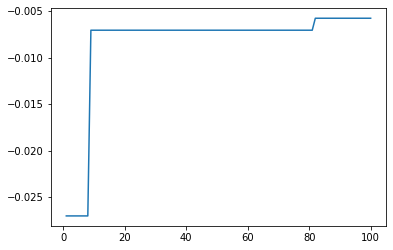

In [51]:

df_plot = df_i.query('iter>0')
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['iter']
y = df_plot['loss_estimate']

plt.plot(x, best_value)
#plt.legend(title='Parameter where:')
plt.show()

In [52]:
df_i.query('loss_estimate<0.010')

,x1,x2,x3,x4,loss_estimate,iter
0,793.123176,914.414576,875.417146,543.509083,0.007065,8
0,844.529182,932.658318,867.896897,562.196233,0.007094,73
0,911.558207,569.716499,908.816942,933.124801,0.005780,81
0,942.596111,621.096461,887.826270,918.379956,0.008735,99


In [53]:
df_i.to_csv('./data/vanilla_bo.csv',index=None)